In [1]:
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model, Model
from keras.layers import Input, Dense, Dropout, Activation, Flatten, Lambda
from keras.layers import Convolution2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers.noise import GaussianNoise
from keras.layers.normalization import BatchNormalization
from keras.applications import InceptionV3, Xception, ResNet50, VGG16, VGG19,InceptionResNetV2
from keras.applications import inception_v3, xception, resnet50, vgg16, vgg19,inception_resnet_v2
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from keras.optimizers import SGD

import os
import sys
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from time import time
from keras.utils import to_categorical
from tqdm import tqdm
from time import time
from datetime import datetime
%matplotlib inline

np.random.seed(2017)

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
from keras.preprocessing import image  

def path_to_tensor(img_path, size):
    img = image.load_img(img_path, target_size=(size, size))
    x = image.img_to_array(img)
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths, size, train):
    paths = [os.path.join(img_paths, f)  for f in os.listdir(img_paths)]
    list_of_tensors = [path_to_tensor(img_path, size) for img_path in tqdm(paths)]
    
    if train == 1:
        y = [int(img_path.split('/')[-1][:3] == 'dog') for img_path in paths]
        name = [f for f in os.listdir(img_paths)]
        return (np.vstack(list_of_tensors), np.array(y), name)
    else:
        index = [int(img_path.split('/')[-1].split('.')[0]) for img_path in paths]
        return (np.vstack(list_of_tensors), index)

In [3]:
def model_print(history):
    fig = plt.figure()
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'])
def model_test(model, X_test, test_index):
    y_pred = model.predict(X_test)
    y_pred = y_pred.clip(min=0.005, max=0.995)

    y_pred = y_pred.reshape((12500,))
    df = pd.DataFrame(data={'id': test_index, 'label':y_pred}).sort_values(by='id')
    df.to_csv('submission.csv', index=None)

In [4]:
#异常检验
from keras.applications import resnet50,xception,inception_resnet_v2

dogs = [
 'n02085620','n02085782','n02085936','n02086079'
,'n02086240','n02086646','n02086910','n02087046'
,'n02087394','n02088094','n02088238','n02088364'
,'n02088466','n02088632','n02089078','n02089867'
,'n02089973','n02090379','n02090622','n02090721'
,'n02091032','n02091134','n02091244','n02091467'
,'n02091635','n02091831','n02092002','n02092339'
,'n02093256','n02093428','n02093647','n02093754'
,'n02093859','n02093991','n02094114','n02094258'
,'n02094433','n02095314','n02095570','n02095889'
,'n02096051','n02096177','n02096294','n02096437'
,'n02096585','n02097047','n02097130','n02097209'
,'n02097298','n02097474','n02097658','n02098105'
,'n02098286','n02098413','n02099267','n02099429'
,'n02099601','n02099712','n02099849','n02100236'
,'n02100583','n02100735','n02100877','n02101006'
,'n02101388','n02101556','n02102040','n02102177'
,'n02102318','n02102480','n02102973','n02104029'
,'n02104365','n02105056','n02105162','n02105251'
,'n02105412','n02105505','n02105641','n02105855'
,'n02106030','n02106166','n02106382','n02106550'
,'n02106662','n02107142','n02107312','n02107574'
,'n02107683','n02107908','n02108000','n02108089'
,'n02108422','n02108551','n02108915','n02109047'
,'n02109525','n02109961','n02110063','n02110185'
,'n02110341','n02110627','n02110806','n02110958'
,'n02111129','n02111277','n02111500','n02111889'
,'n02112018','n02112137','n02112350','n02112706'
,'n02113023','n02113186','n02113624','n02113712'
,'n02113799','n02113978']

cats=[
'n02123045','n02123159','n02123394','n02123597'
,'n02124075','n02125311','n02127052']

def find(x, l):
    rst = False
    for i in x:
        if i in l:
            rst = True
            break
    return rst

X, train_label, train_name = paths_to_tensor('data/train/', 224, 1)
model = ResNet50(weights='imagenet')
x = resnet50.preprocess_input(X)

preds = model.predict(x)

topn = list(zip([[y[0] for y in x]  for x in resnet50.decode_predictions(preds, top=80)], train_name))
abnormal_resnet50 = [x for x in topn if ((not find(x[0], dogs)) and (not find(x[0], cats)))]
print(len(abnormal_resnet50))

100%|██████████| 25000/25000 [01:37<00:00, 255.22it/s]


26


In [5]:
X, train_label, train_name = paths_to_tensor('data/train/', 224, 1)
model = Xception(weights='imagenet')
x = xception.preprocess_input(X)

preds = model.predict(x)

topn = list(zip([[y[0] for y in x]  for x in xception.decode_predictions(preds, top=80)], train_name))
abnormal_xception = [x for x in topn if ((not find(x[0], dogs)) and (not find(x[0], cats)))]
print(len(abnormal_xception))

100%|██████████| 25000/25000 [01:07<00:00, 369.40it/s]


26


In [6]:
X, train_label, train_name = paths_to_tensor('data/train/', 224, 1)
model = InceptionResNetV2(weights='imagenet')
x = inception_resnet_v2.preprocess_input(X)

preds = model.predict(x)

topn = list(zip([[y[0] for y in x]  for x in inception_resnet_v2.decode_predictions(preds, top=80)], train_name))
abnormal_inceptionResNetV2 = [x for x in topn if ((not find(x[0], dogs)) and (not find(x[0], cats)))]
print(len(abnormal_inceptionResNetV2))

100%|██████████| 25000/25000 [01:09<00:00, 361.15it/s]


25


In [7]:
abnornal_all = list(set([x[1] for x in abnormal_resnet50] + [x[1] for x in abnormal_xception] + [x[1] for x in abnormal_inceptionResNetV2]))
print(len(abnornal_all))
abnornal_all

50


['cat.9983.jpg',
 'cat.3672.jpg',
 'dog.4367.jpg',
 'cat.7377.jpg',
 'cat.11184.jpg',
 'cat.10712.jpg',
 'cat.2433.jpg',
 'cat.4688.jpg',
 'dog.1194.jpg',
 'cat.6402.jpg',
 'dog.11266.jpg',
 'cat.5974.jpg',
 'dog.5604.jpg',
 'dog.2422.jpg',
 'cat.5418.jpg',
 'dog.12376.jpg',
 'dog.10190.jpg',
 'cat.9391.jpg',
 'cat.7564.jpg',
 'cat.7968.jpg',
 'cat.2520.jpg',
 'dog.8898.jpg',
 'dog.9517.jpg',
 'cat.4308.jpg',
 'cat.6817.jpg',
 'dog.6725.jpg',
 'dog.8736.jpg',
 'dog.10161.jpg',
 'dog.9188.jpg',
 'cat.8456.jpg',
 'dog.1625.jpg',
 'cat.4338.jpg',
 'dog.10123.jpg',
 'cat.12424.jpg',
 'dog.1773.jpg',
 'cat.9520.jpg',
 'dog.6475.jpg',
 'dog.2614.jpg',
 'dog.11299.jpg',
 'cat.9171.jpg',
 'cat.9494.jpg',
 'dog.10747.jpg',
 'dog.10237.jpg',
 'cat.10536.jpg',
 'dog.10801.jpg',
 'cat.12203.jpg',
 'cat.10029.jpg',
 'cat.2939.jpg',
 'dog.4218.jpg',
 'dog.2339.jpg']

In [4]:
def image_print(image):
    cv_rgb = cv2.cvtColor(cv2.imread(image), cv2.COLOR_BGR2RGB)
    plt.imshow(cv_rgb)

In [52]:
def paths_to_size(img_paths):
    paths = [os.path.join(img_paths, f)  for f in os.listdir(img_paths)]
    return [cv2.imread(img_path).shape[:2] for img_path in tqdm(paths)]

In [59]:
cat_size = pd.DataFrame(paths_to_size('data/train2/cat/'), columns=['wide', 'height'])
cat_size.describe()

100%|██████████| 12500/12500 [00:28<00:00, 434.36it/s]


,wide,height
count,12500.000000,12500.000000
mean,356.467120,410.522640
std,96.526665,107.882752
min,32.000000,50.000000
25%,300.000000,334.000000
50%,374.000000,470.000000
75%,406.250000,499.000000
max,768.000000,1023.000000


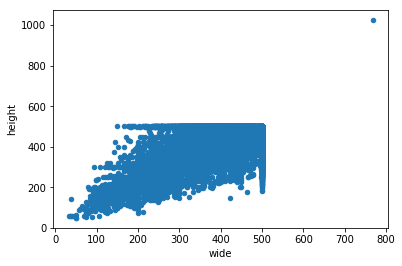

In [61]:
cat_size.plot(kind='scatter', x='wide', y='height')

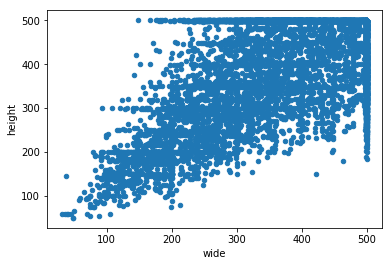

In [68]:
cat_size[cat_size.wide < 600].plot(kind='scatter', x='wide', y='height')

In [62]:
dog_size = pd.DataFrame(paths_to_size('data/train2/dog/'), columns=['wide', 'height'])
dog_size.describe()

100%|██████████| 12500/12500 [00:39<00:00, 316.48it/s]


,wide,height
count,12500.000000,12500.000000
mean,364.489040,397.675440
std,97.349489,109.810161
min,33.000000,42.000000
25%,306.750000,319.000000
50%,374.000000,423.000000
75%,434.000000,499.000000
max,702.000000,1050.000000


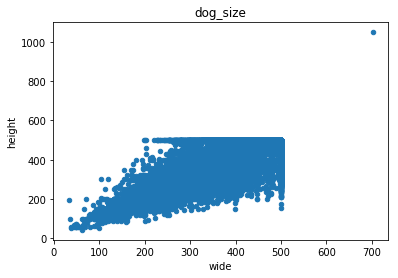

In [77]:
dog_size.plot(kind='scatter', x='wide', y='height', title='dog_size')

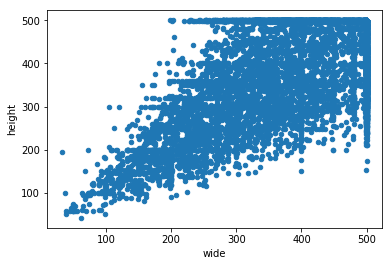

In [67]:
dog_size[dog_size.wide < 600].plot(kind='scatter', x='wide', y='height')

异常分别率图片

In [73]:
paths = [os.path.join('data/train2/cat/', f)  for f in os.listdir('data/train2/cat/')]
[img_path for img_path in tqdm(paths) if cv2.imread(img_path).shape[0] > 600]

100%|██████████| 12500/12500 [00:28<00:00, 435.23it/s]


['data/train2/cat/cat.835.jpg']

In [74]:
paths = [os.path.join('data/train2/dog/', f)  for f in os.listdir('data/train2/dog/')]
[img_path for img_path in tqdm(paths) if cv2.imread(img_path).shape[0] > 600]

100%|██████████| 12500/12500 [00:29<00:00, 420.84it/s]


['data/train2/dog/dog.2317.jpg']

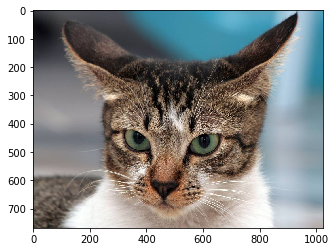

In [75]:
image_print('data/train2/cat/cat.835.jpg')

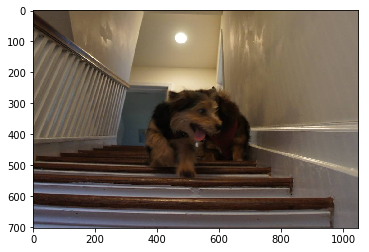

In [76]:
image_print('data/train2/dog/dog.2317.jpg')

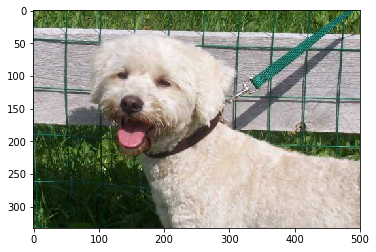

In [32]:
image_print('data/train2/dog/dog.143.jpg')

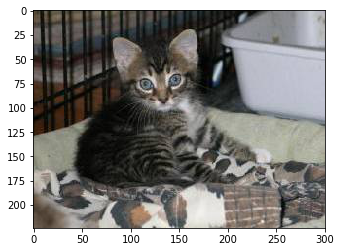

In [14]:
image_print('data/train2/cat/cat.12.jpg')

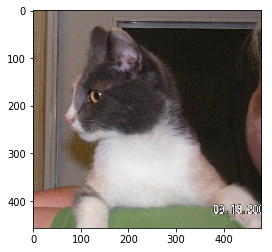

In [24]:
image_print('data/train2/cat/cat.135.jpg')

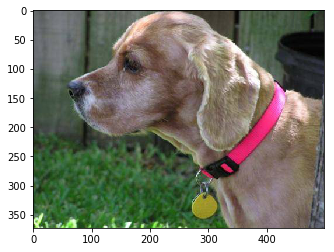

In [27]:
image_print('data/train2/dog/dog.102.jpg')

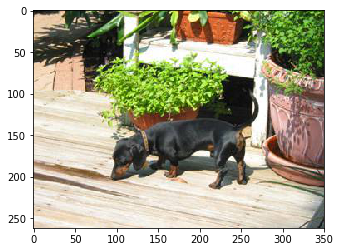

In [47]:
image_print('data/train2/dog/dog.2256.jpg')

In [5]:
#244*244*3

X, train_label, name = paths_to_tensor('data/train/', 244, 1)
X_test, test_index = paths_to_tensor('data/test/', 244, 0)

100%|██████████| 12500/12500 [00:45<00:00, 274.16it/s]


Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 63s 3ms/step - loss: 0.1564 - acc: 0.9694 - val_loss: 0.0715 - val_acc: 0.9844
Epoch 2/10
20000/20000 [==============================] - 61s 3ms/step - loss: 0.1103 - acc: 0.9762 - val_loss: 0.0697 - val_acc: 0.9854
Epoch 3/10
20000/20000 [==============================] - 62s 3ms/step - loss: 0.1003 - acc: 0.9786 - val_loss: 0.0684 - val_acc: 0.9854
Epoch 4/10
20000/20000 [==============================] - 61s 3ms/step - loss: 0.1107 - acc: 0.9784 - val_loss: 0.0765 - val_acc: 0.9854
Epoch 5/10
20000/20000 [==============================] - 61s 3ms/step - loss: 0.0926 - acc: 0.9801 - val_loss: 0.0652 - val_acc: 0.9858
Epoch 6/10
20000/20000 [==============================] - 61s 3ms/step - loss: 0.1058 - acc: 0.9779 - val_loss: 0.1169 - val_acc: 0.9748
Epoch 7/10
20000/20000 [==============================] - 61s 3ms/step - loss: 0.1070 - acc: 0.9788 - val_loss: 0.0710 - val_acc:

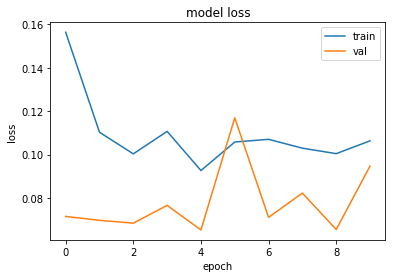

In [5]:
#vgg16 基准 0.08173

from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, train_label, shuffle=True, test_size=0.2, random_state=42)

#VGG16 base
x = Input(shape=(244, 244, 3))
x = Lambda(vgg16.preprocess_input)(x)

base_model = VGG16(include_top=False, input_tensor=x, weights='imagenet', pooling='avg')
for layer in base_model.layers:
    layer.trainable = False
    
# 自定义分类层
y = Dropout(0.2)(base_model.output)
y = Dense(1, activation='sigmoid', kernel_initializer='he_normal')(y)

model = Model(inputs=base_model.input, outputs=y, name='Transfer_Learning')
sgd = SGD(lr=1e-3, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy'])

log_name = '/dogcat-EP{epoch:02d}-LOSS{val_loss:.4f}.h5'
log_dir = datetime.now().strftime('transfer_model_%Y%m%d_%H%M')
if not os.path.exists(log_dir):
    os.mkdir(log_dir)

es = EarlyStopping(monitor='val_loss', patience=20)
mc = ModelCheckpoint(log_dir + log_name, monitor='val_loss', save_best_only=True)
tb = TensorBoard(log_dir=log_dir)

history = model.fit(x=X_train, y=y_train, batch_size=16, epochs=10, validation_data=(X_val, y_val), callbacks=[es, mc, tb])

#模型打印
model_print(history)
#测试集
model_test(model, X_test, test_index)

In [6]:
#融合
import h5py
from keras.applications import inception_v3, xception, VGG19, Xception, inception_resnet_v2,InceptionResNetV2
from keras.layers import Lambda
from keras.models import *
from keras.layers import *
from keras.applications import *
from keras.preprocessing.image import *

def export_gap(MODEL, size, preprocess=None, ext=False):
    x = Input((size[0], size[1], 3))
    if preprocess:
        x = Lambda(preprocess)(x)
    model = MODEL(input_tensor=x, weights='imagenet', include_top=False, pooling='avg')

    train_gap = model.predict(X, batch_size=256)
    test_gap = model.predict(X_test, batch_size=256)
    
    if ext:
        with h5py.File("gap_%s_ext.h5" % MODEL.__name__, 'w') as f:
            f.create_dataset('train', data=train_gap)
            f.create_dataset('test', data=test_gap)
    else:
        with h5py.File("gap_%s.h5" % MODEL.__name__, 'w') as f:
            f.create_dataset('train', data=train_gap)
            f.create_dataset('test', data=test_gap)
            
#分批读入
def export_gap2(MODEL, size, preprocess=None, ext=False):
    input_tensor = Input((size[0], size[1], 3))
    x = input_tensor
    if preprocess:
        x = Lambda(preprocess)(x)

    model = MODEL(input_tensor=x, weights='imagenet', include_top=False, pooling='avg')

    gen = ImageDataGenerator()
    train_generator = gen.flow_from_directory("data/train2", size, shuffle=False, 
                                              batch_size=64)
    test_generator = gen.flow_from_directory("data/test", size, shuffle=False, 
                                             batch_size=64, class_mode=None)

    train = model.predict_generator(train_generator, train_generator.samples)
    test = model.predict_generator(test_generator, test_generator.samples)
    
    if ext:
        with h5py.File("gap_%s_ext.h5" % MODEL.__name__, 'w') as h:
            h.create_dataset("train", data=train)
            h.create_dataset("test", data=test)
            h.create_dataset("label", data=train_generator.classes)
    else:
        with h5py.File("gap_%s.h5" % MODEL.__name__, 'w') as h:
            h.create_dataset("train", data=train)
            h.create_dataset("test", data=test)
            h.create_dataset("label", data=train_generator.classes)

In [6]:
#特征向量提取
export_gap(InceptionV3, (244,244), inception_v3.preprocess_input)
export_gap(Xception, (244,244), xception.preprocess_input)
export_gap(InceptionResNetV2, (244,244), inception_resnet_v2.preprocess_input)

In [5]:
import h5py
from sklearn.utils import shuffle

train = []
test = []
for file in ['gap_InceptionV3.h5', 'gap_InceptionResNetV2.h5', 'gap_Xception.h5']:
    with h5py.File(file, 'r') as f:
        train.append(np.array(f['train']))
        test.append(np.array(f['test']))
train = np.concatenate(train, axis=1)
test = np.concatenate(test, axis=1)
print(train.shape)

(25000, 5632)


In [6]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(train, train_label, shuffle=True, test_size=0.2, random_state=42)

**使用Adadelta优化器**

In [8]:
# 0.03951
inputs = Input((X_train.shape[1],))
x = inputs
x = Dropout(0.25)(x)
y = Dense(1, activation='sigmoid')(x)

model = Model(inputs=inputs, outputs=y)
model.compile(loss='binary_crossentropy', optimizer='adadelta', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 5632)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 5632)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 5633      
Total params: 5,633
Trainable params: 5,633
Non-trainable params: 0
_________________________________________________________________


Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 3s 163us/step - loss: 0.0744 - acc: 0.9766 - val_loss: 0.0217 - val_acc: 0.9922
Epoch 2/10
20000/20000 [==============================] - 1s 29us/step - loss: 0.0213 - acc: 0.9932 - val_loss: 0.0139 - val_acc: 0.9952
Epoch 3/10
20000/20000 [==============================] - 1s 29us/step - loss: 0.0163 - acc: 0.9950 - val_loss: 0.0137 - val_acc: 0.9958
Epoch 4/10
20000/20000 [==============================] - 1s 29us/step - loss: 0.0147 - acc: 0.9953 - val_loss: 0.0134 - val_acc: 0.9950
Epoch 5/10
20000/20000 [==============================] - 1s 29us/step - loss: 0.0139 - acc: 0.9957 - val_loss: 0.0140 - val_acc: 0.9952
Epoch 6/10
20000/20000 [==============================] - 1s 29us/step - loss: 0.0121 - acc: 0.9963 - val_loss: 0.0164 - val_acc: 0.9950
Epoch 7/10
20000/20000 [==============================] - 1s 29us/step - loss: 0.0114 - acc: 0.9963 - val_loss: 0.0135 - val_acc

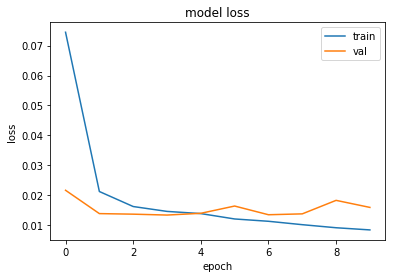

In [9]:
history = model.fit(x=X_train, y=y_train, batch_size=128, epochs=10, validation_data=(X_val, y_val))

#模型打印
model_print(history)
#测试集
model_test(model, test, test_index)

In [11]:
#gridsearch 选取batch_size
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import log_loss, make_scorer
from keras.wrappers.scikit_learn import KerasClassifier

def create_model(dropout, optimizer='adadelta'):
    inputs = Input((train.shape[1],))
    x = inputs
    x = Dropout(dropout)(x)
    y = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=inputs, outputs=y)
    model.compile(loss='binary_crossentropy', optimizer='adadelta', metrics=['accuracy'])
    return model
        
model = KerasClassifier(build_fn=create_model, verbose=0)

batch_size = [32, 64, 128, 256]
epochs = [10]
dropout = [0.25]

scorer = make_scorer(log_loss, greater_is_better=False)

param_grid = dict(batch_size=batch_size, nb_epoch=epochs, dropout=dropout)
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring=scorer)

grid_result = grid.fit(train, train_label)

In [14]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
for params, mean_score, scores in grid_result.grid_scores_:
    print("%f (%f) with: %r" % (scores.mean(), scores.std(), params))

Best: -0.218289 using {'batch_size': 32, 'dropout': 0.25, 'nb_epoch': 10}
-0.218289 (0.056897) with: {'batch_size': 32, 'dropout': 0.25, 'nb_epoch': 10}
-0.250064 (0.069956) with: {'batch_size': 64, 'dropout': 0.25, 'nb_epoch': 10}
-0.276315 (0.075799) with: {'batch_size': 128, 'dropout': 0.25, 'nb_epoch': 10}
-0.288750 (0.055677) with: {'batch_size': 256, 'dropout': 0.25, 'nb_epoch': 10}


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


batch_size选择32，测试集logloss0.03947

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 2s 102us/step - loss: 0.0352 - acc: 0.9899 - val_loss: 0.0160 - val_acc: 0.9948
Epoch 2/10
20000/20000 [==============================] - 2s 92us/step - loss: 0.0170 - acc: 0.9949 - val_loss: 0.0151 - val_acc: 0.9950
Epoch 3/10
20000/20000 [==============================] - 2s 91us/step - loss: 0.0145 - acc: 0.9954 - val_loss: 0.0148 - val_acc: 0.9950
Epoch 4/10
20000/20000 [==============================] - 2s 91us/step - loss: 0.0136 - acc: 0.9960 - val_loss: 0.0154 - val_acc: 0.9946
Epoch 5/10
20000/20000 [==============================] - 2s 91us/step - loss: 0.0123 - acc: 0.9963 - val_loss: 0.0162 - val_acc: 0.9950
Epoch 6/10
20000/20000 [==============================] - 2s 92us/step - loss: 0.0108 - acc: 0.9963 - val_loss: 0.0170 - val_acc: 0.9952
Epoch 7/10
20000/20000 [==============================] - 2s 92us/step - loss: 0.0102 - acc: 0.9970 - val_loss: 0.0170 - val_acc

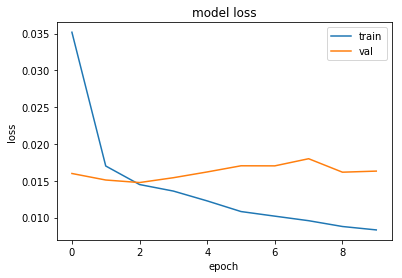

In [10]:
# batch_size 修改为32 0.03947
inputs = Input((X_train.shape[1],))
x = inputs
x = Dropout(0.25)(x)
y = Dense(1, activation='sigmoid')(x)

model = Model(inputs=inputs, outputs=y)
model.compile(loss='binary_crossentropy', optimizer='adadelta', metrics=['accuracy'])

history = model.fit(x=X_train, y=y_train, batch_size=32, epochs=10, validation_data=(X_val, y_val))

#模型打印
model_print(history)
#测试集
model_test(model, test, test_index)

In [11]:
#gridsearch 选取epochs 
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import log_loss, make_scorer
from keras.wrappers.scikit_learn import KerasClassifier

def create_model(dropout, optimizer='adadelta'):
    inputs = Input((train.shape[1],))
    x = inputs
    x = Dropout(dropout)(x)
    y = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=inputs, outputs=y)
    model.compile(loss='binary_crossentropy', optimizer='adadelta', metrics=['accuracy'])
    return model
        
model = KerasClassifier(build_fn=create_model, verbose=0)

batch_size = [32]
epochs = [10, 15, 20]
dropout = [0.25]

scorer = make_scorer(log_loss, greater_is_better=False)

param_grid = dict(batch_size=batch_size, nb_epoch=epochs, dropout=dropout)
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring=scorer)

grid_result = grid.fit(train, train_label)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
for params, mean_score, scores in grid_result.grid_scores_:
    print("%f (%f) with: %r" % (scores.mean(), scores.std(), params))

Best: -0.200327 using {'batch_size': 32, 'dropout': 0.25, 'nb_epoch': 10}
-0.200327 (0.020952) with: {'batch_size': 32, 'dropout': 0.25, 'nb_epoch': 10}
-0.221051 (0.030893) with: {'batch_size': 32, 'dropout': 0.25, 'nb_epoch': 15}
-0.205854 (0.022870) with: {'batch_size': 32, 'dropout': 0.25, 'nb_epoch': 20}


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


epochs选择10，与前一次一致。

In [12]:
#gridsearch 选取dropout
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import log_loss, make_scorer
from keras.wrappers.scikit_learn import KerasClassifier

def create_model(dropout, optimizer='adadelta'):
    inputs = Input((train.shape[1],))
    x = inputs
    x = Dropout(dropout)(x)
    y = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=inputs, outputs=y)
    model.compile(loss='binary_crossentropy', optimizer='adadelta', metrics=['accuracy'])
    return model
        
model = KerasClassifier(build_fn=create_model, verbose=0)

batch_size = [32]
epochs = [10]
dropout = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

scorer = make_scorer(log_loss, greater_is_better=False)

param_grid = dict(batch_size=batch_size, nb_epoch=epochs, dropout=dropout)
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring=scorer)

grid_result = grid.fit(train, train_label)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: -0.196183 using {'batch_size': 32, 'dropout': 0.7, 'nb_epoch': 10}


In [13]:
for params, mean_score, scores in grid_result.grid_scores_:
    print("%f (%f) with: %r" % (scores.mean(), scores.std(), params))

-0.198946 (0.019732) with: {'batch_size': 32, 'dropout': 0.1, 'nb_epoch': 10}
-0.230721 (0.021223) with: {'batch_size': 32, 'dropout': 0.2, 'nb_epoch': 10}
-0.236249 (0.073420) with: {'batch_size': 32, 'dropout': 0.3, 'nb_epoch': 10}
-0.241776 (0.077048) with: {'batch_size': 32, 'dropout': 0.4, 'nb_epoch': 10}
-0.215526 (0.030079) with: {'batch_size': 32, 'dropout': 0.5, 'nb_epoch': 10}
-0.221052 (0.052971) with: {'batch_size': 32, 'dropout': 0.6, 'nb_epoch': 10}
-0.196183 (0.007045) with: {'batch_size': 32, 'dropout': 0.7, 'nb_epoch': 10}
-0.212762 (0.030707) with: {'batch_size': 32, 'dropout': 0.8, 'nb_epoch': 10}
-0.295658 (0.050838) with: {'batch_size': 32, 'dropout': 0.9, 'nb_epoch': 10}


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 4s 183us/step - loss: 0.0403 - acc: 0.9874 - val_loss: 0.0161 - val_acc: 0.9946
Epoch 2/10
20000/20000 [==============================] - 2s 105us/step - loss: 0.0249 - acc: 0.9919 - val_loss: 0.0180 - val_acc: 0.9946
Epoch 3/10
20000/20000 [==============================] - 2s 105us/step - loss: 0.0228 - acc: 0.9932 - val_loss: 0.0187 - val_acc: 0.9940
Epoch 4/10
20000/20000 [==============================] - 2s 104us/step - loss: 0.0216 - acc: 0.9936 - val_loss: 0.0147 - val_acc: 0.9952
Epoch 5/10
20000/20000 [==============================] - 2s 104us/step - loss: 0.0211 - acc: 0.9936 - val_loss: 0.0148 - val_acc: 0.9952
Epoch 6/10
20000/20000 [==============================] - 2s 104us/step - loss: 0.0202 - acc: 0.9940 - val_loss: 0.0164 - val_acc: 0.9946
Epoch 7/10
20000/20000 [==============================] - 2s 104us/step - loss: 0.0191 - acc: 0.9941 - val_loss: 0.0150 - v

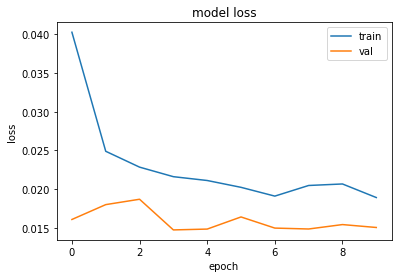

In [15]:
# dropout修改为  0.7 0.03924 
inputs = Input((X_train.shape[1],))
x = inputs
x = Dropout(0.7)(x)
y = Dense(1, activation='sigmoid')(x)

model = Model(inputs=inputs, outputs=y)
model.compile(loss='binary_crossentropy', optimizer='adadelta', metrics=['accuracy'])

history = model.fit(x=X_train, y=y_train, batch_size=32, epochs=10, validation_data=(X_val, y_val))

#模型打印
model_print(history)
#测试集
model_test(model, test, test_index)

**优化器：Adadelta**  
batch_size=32,epochs=10,dropout=0.7 测试集logloss0.03924

**使用RMSprop优化器**

In [7]:
#gridsearch 选取RMSprop lr
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import log_loss, make_scorer
from keras.wrappers.scikit_learn import KerasClassifier
from keras.optimizers import RMSprop

def create_model(dropout, lr):
    inputs = Input((train.shape[1],))
    x = inputs
    x = Dropout(dropout)(x)
    y = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=inputs, outputs=y)
    model.compile(loss='binary_crossentropy', optimizer=RMSprop(lr=lr), metrics=['accuracy'])
    return model
        
model = KerasClassifier(build_fn=create_model, verbose=0)

batch_size = [16, 32, 64]
epochs = [10]
dropout = [0.5]
lr = [0.001]

scorer = make_scorer(log_loss, greater_is_better=False)

param_grid = dict(batch_size=batch_size, nb_epoch=epochs, dropout=dropout, lr=lr)
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring=scorer)

grid_result = grid.fit(train, train_label)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
for params, mean_score, scores in grid_result.grid_scores_:
    print("%f (%f) with: %r" % (scores.mean(), scores.std(), params))

Best: -0.196183 using {'batch_size': 64, 'dropout': 0.5, 'lr': 0.001, 'nb_epoch': 10}
-0.209999 (0.014224) with: {'batch_size': 16, 'dropout': 0.5, 'lr': 0.001, 'nb_epoch': 10}
-0.251446 (0.105092) with: {'batch_size': 32, 'dropout': 0.5, 'lr': 0.001, 'nb_epoch': 10}
-0.196183 (0.012812) with: {'batch_size': 64, 'dropout': 0.5, 'lr': 0.001, 'nb_epoch': 10}


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


In [8]:
#gridsearch 选取RMSprop lr
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import log_loss, make_scorer
from keras.wrappers.scikit_learn import KerasClassifier
from keras.optimizers import RMSprop

def create_model(dropout, lr):
    inputs = Input((train.shape[1],))
    x = inputs
    x = Dropout(dropout)(x)
    y = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=inputs, outputs=y)
    model.compile(loss='binary_crossentropy', optimizer=RMSprop(lr=lr), metrics=['accuracy'])
    return model
        
model = KerasClassifier(build_fn=create_model, verbose=0)

batch_size = [64]
epochs = [10, 15 ,20]
dropout = [0.5]
lr = [0.001]

scorer = make_scorer(log_loss, greater_is_better=False)

param_grid = dict(batch_size=batch_size, nb_epoch=epochs, dropout=dropout, lr=lr)
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring=scorer)

grid_result = grid.fit(train, train_label)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
for params, mean_score, scores in grid_result.grid_scores_:
    print("%f (%f) with: %r" % (scores.mean(), scores.std(), params))

Best: -0.193420 using {'batch_size': 64, 'dropout': 0.5, 'lr': 0.001, 'nb_epoch': 20}
-0.250065 (0.046526) with: {'batch_size': 64, 'dropout': 0.5, 'lr': 0.001, 'nb_epoch': 10}
-0.227958 (0.050761) with: {'batch_size': 64, 'dropout': 0.5, 'lr': 0.001, 'nb_epoch': 15}
-0.193420 (0.022702) with: {'batch_size': 64, 'dropout': 0.5, 'lr': 0.001, 'nb_epoch': 20}


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


In [9]:
#gridsearch 选取RMSprop lr
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import log_loss, make_scorer
from keras.wrappers.scikit_learn import KerasClassifier
from keras.optimizers import RMSprop

def create_model(dropout, lr):
    inputs = Input((train.shape[1],))
    x = inputs
    x = Dropout(dropout)(x)
    y = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=inputs, outputs=y)
    model.compile(loss='binary_crossentropy', optimizer=RMSprop(lr=lr), metrics=['accuracy'])
    return model
        
model = KerasClassifier(build_fn=create_model, verbose=0)

batch_size = [64]
epochs = [20]
dropout = [0.1, 0.25, 0.5, 0.75, 0.9]
lr = [0.001]

scorer = make_scorer(log_loss, greater_is_better=False)

param_grid = dict(batch_size=batch_size, nb_epoch=epochs, dropout=dropout, lr=lr)
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring=scorer)

grid_result = grid.fit(train, train_label)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
for params, mean_score, scores in grid_result.grid_scores_:
    print("%f (%f) with: %r" % (scores.mean(), scores.std(), params))

Best: -0.216907 using {'batch_size': 64, 'dropout': 0.5, 'lr': 0.001, 'nb_epoch': 20}
-0.244539 (0.084334) with: {'batch_size': 64, 'dropout': 0.1, 'lr': 0.001, 'nb_epoch': 20}
-0.268025 (0.087423) with: {'batch_size': 64, 'dropout': 0.25, 'lr': 0.001, 'nb_epoch': 20}
-0.216907 (0.045739) with: {'batch_size': 64, 'dropout': 0.5, 'lr': 0.001, 'nb_epoch': 20}
-0.223815 (0.047780) with: {'batch_size': 64, 'dropout': 0.75, 'lr': 0.001, 'nb_epoch': 20}
-0.284605 (0.036658) with: {'batch_size': 64, 'dropout': 0.9, 'lr': 0.001, 'nb_epoch': 20}


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


In [10]:
#gridsearch 选取RMSprop lr
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import log_loss, make_scorer
from keras.wrappers.scikit_learn import KerasClassifier
from keras.optimizers import RMSprop

def create_model(dropout, lr):
    inputs = Input((train.shape[1],))
    x = inputs
    x = Dropout(dropout)(x)
    y = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=inputs, outputs=y)
    model.compile(loss='binary_crossentropy', optimizer=RMSprop(lr=lr), metrics=['accuracy'])
    return model
        
model = KerasClassifier(build_fn=create_model, verbose=0)

batch_size = [64]
epochs = [20]
dropout = [0.5]
lr = [0.0001, 0.001, 0.01, 0.1]

scorer = make_scorer(log_loss, greater_is_better=False)

param_grid = dict(batch_size=batch_size, nb_epoch=epochs, dropout=dropout, lr=lr)
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring=scorer)

grid_result = grid.fit(train, train_label)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
for params, mean_score, scores in grid_result.grid_scores_:
    print("%f (%f) with: %r" % (scores.mean(), scores.std(), params))

Best: -0.197564 using {'batch_size': 64, 'dropout': 0.5, 'lr': 0.001, 'nb_epoch': 20}
-0.306711 (0.026790) with: {'batch_size': 64, 'dropout': 0.5, 'lr': 0.0001, 'nb_epoch': 20}
-0.197564 (0.029824) with: {'batch_size': 64, 'dropout': 0.5, 'lr': 0.001, 'nb_epoch': 20}
-3.690125 (6.879533) with: {'batch_size': 64, 'dropout': 0.5, 'lr': 0.01, 'nb_epoch': 20}
-7.188214 (8.356943) with: {'batch_size': 64, 'dropout': 0.5, 'lr': 0.1, 'nb_epoch': 20}


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


Train on 20000 samples, validate on 5000 samples
Epoch 1/20
20000/20000 [==============================] - 3s 137us/step - loss: 0.0524 - acc: 0.9838 - val_loss: 0.0163 - val_acc: 0.9942
Epoch 2/20
20000/20000 [==============================] - 1s 54us/step - loss: 0.0211 - acc: 0.9936 - val_loss: 0.0152 - val_acc: 0.9950
Epoch 3/20
20000/20000 [==============================] - 1s 55us/step - loss: 0.0177 - acc: 0.9944 - val_loss: 0.0159 - val_acc: 0.9948
Epoch 4/20
20000/20000 [==============================] - 1s 54us/step - loss: 0.0183 - acc: 0.9951 - val_loss: 0.0155 - val_acc: 0.9944
Epoch 5/20
20000/20000 [==============================] - 1s 54us/step - loss: 0.0165 - acc: 0.9956 - val_loss: 0.0158 - val_acc: 0.9948
Epoch 6/20
20000/20000 [==============================] - 1s 54us/step - loss: 0.0155 - acc: 0.9955 - val_loss: 0.0207 - val_acc: 0.9936
Epoch 7/20
20000/20000 [==============================] - 1s 54us/step - loss: 0.0169 - acc: 0.9953 - val_loss: 0.0179 - val_acc

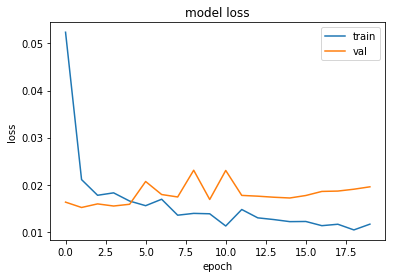

In [12]:
# 优化器 修改为 RMSprop lr=0.001  0.04013
from keras.optimizers import RMSprop
inputs = Input((X_train.shape[1],))
x = inputs
x = Dropout(0.5)(x)
y = Dense(1, activation='sigmoid')(x)

model = Model(inputs=inputs, outputs=y)
model.compile(loss='binary_crossentropy', optimizer=RMSprop(lr=0.001), metrics=['accuracy'])

history = model.fit(x=X_train, y=y_train, batch_size=64, epochs=20, validation_data=(X_val, y_val))

#模型打印
model_print(history)
#测试集
model_test(model, test, test_index)

Train on 20000 samples, validate on 5000 samples
Epoch 1/20
20000/20000 [==============================] - 4s 183us/step - loss: 0.0783 - acc: 0.9792 - val_loss: 0.0242 - val_acc: 0.9924
Epoch 2/20
20000/20000 [==============================] - 2s 100us/step - loss: 0.0270 - acc: 0.9923 - val_loss: 0.0188 - val_acc: 0.9934
Epoch 3/20
20000/20000 [==============================] - 2s 100us/step - loss: 0.0226 - acc: 0.9929 - val_loss: 0.0172 - val_acc: 0.9940
Epoch 4/20
20000/20000 [==============================] - 2s 100us/step - loss: 0.0206 - acc: 0.9932 - val_loss: 0.0157 - val_acc: 0.9946
Epoch 5/20
20000/20000 [==============================] - 2s 100us/step - loss: 0.0201 - acc: 0.9935 - val_loss: 0.0155 - val_acc: 0.9946
Epoch 6/20
20000/20000 [==============================] - 2s 100us/step - loss: 0.0189 - acc: 0.9944 - val_loss: 0.0153 - val_acc: 0.9948
Epoch 7/20
20000/20000 [==============================] - 2s 100us/step - loss: 0.0175 - acc: 0.9943 - val_loss: 0.0155 - v

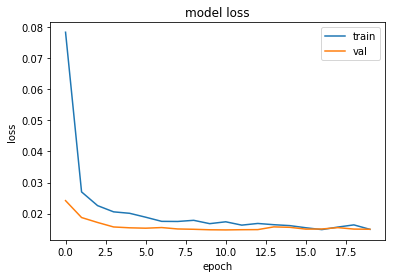

In [13]:
# 优化器 修改为 RMSprop lr=0.0001 0.03916
from keras.optimizers import RMSprop
inputs = Input((X_train.shape[1],))
x = inputs
x = Dropout(0.5)(x)
y = Dense(1, activation='sigmoid')(x)

model = Model(inputs=inputs, outputs=y)
model.compile(loss='binary_crossentropy', optimizer=RMSprop(lr=0.0001), metrics=['accuracy'])

history = model.fit(x=X_train, y=y_train, batch_size=32, epochs=20, validation_data=(X_val, y_val))

#模型打印
model_print(history)
#测试集
model_test(model, test, test_index)

In [19]:
#gridsearch 选取SGD lr, momentum
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import log_loss, make_scorer
from keras.wrappers.scikit_learn import KerasClassifier
from keras.optimizers import SGD

def create_model(dropout, lr, momentum):
    inputs = Input((train.shape[1],))
    x = inputs
    x = Dropout(dropout)(x)
    y = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=inputs, outputs=y)
    model.compile(loss='binary_crossentropy', optimizer=SGD(lr=lr,momentum=momentum,decay=1e-6), metrics=['accuracy'])
    return model
        
model = KerasClassifier(build_fn=create_model, verbose=0)

batch_size = [32]
epochs = [10]
dropout = [0.7]
lr = [0.0001, 0.001, 0.01]
momentum = [0.3, 0.6, 0.9]

scorer = make_scorer(log_loss, greater_is_better=False)

param_grid = dict(batch_size=batch_size, nb_epoch=epochs, dropout=dropout, lr=lr, momentum=momentum)
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring=scorer)

grid_result = grid.fit(train, train_label)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
for params, mean_score, scores in grid_result.grid_scores_:
    print("%f (%f) with: %r" % (scores.mean(), scores.std(), params))

Best: -0.197565 using {'batch_size': 32, 'dropout': 0.7, 'lr': 0.01, 'momentum': 0.6, 'nb_epoch': 10}
-0.580263 (0.061632) with: {'batch_size': 32, 'dropout': 0.7, 'lr': 0.0001, 'momentum': 0.3, 'nb_epoch': 10}
-0.515330 (0.062493) with: {'batch_size': 32, 'dropout': 0.7, 'lr': 0.0001, 'momentum': 0.6, 'nb_epoch': 10}
-0.392369 (0.046113) with: {'batch_size': 32, 'dropout': 0.7, 'lr': 0.0001, 'momentum': 0.9, 'nb_epoch': 10}
-0.379935 (0.038088) with: {'batch_size': 32, 'dropout': 0.7, 'lr': 0.001, 'momentum': 0.3, 'nb_epoch': 10}
-0.305329 (0.037430) with: {'batch_size': 32, 'dropout': 0.7, 'lr': 0.001, 'momentum': 0.6, 'nb_epoch': 10}
-0.229342 (0.021581) with: {'batch_size': 32, 'dropout': 0.7, 'lr': 0.001, 'momentum': 0.9, 'nb_epoch': 10}
-0.209999 (0.018329) with: {'batch_size': 32, 'dropout': 0.7, 'lr': 0.01, 'momentum': 0.3, 'nb_epoch': 10}
-0.197565 (0.022953) with: {'batch_size': 32, 'dropout': 0.7, 'lr': 0.01, 'momentum': 0.6, 'nb_epoch': 10}
-0.263881 (0.087314) with: {'batc

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 5s 271us/step - loss: 0.0427 - acc: 0.9865 - val_loss: 0.0175 - val_acc: 0.9944
Epoch 2/10
20000/20000 [==============================] - 2s 112us/step - loss: 0.0265 - acc: 0.9923 - val_loss: 0.0212 - val_acc: 0.9930
Epoch 3/10
20000/20000 [==============================] - 2s 111us/step - loss: 0.0234 - acc: 0.9933 - val_loss: 0.0231 - val_acc: 0.9918
Epoch 4/10
20000/20000 [==============================] - 2s 112us/step - loss: 0.0231 - acc: 0.9931 - val_loss: 0.0233 - val_acc: 0.9932
Epoch 5/10
20000/20000 [==============================] - 2s 112us/step - loss: 0.0192 - acc: 0.9940 - val_loss: 0.0183 - val_acc: 0.9944
Epoch 6/10
20000/20000 [==============================] - 2s 111us/step - loss: 0.0200 - acc: 0.9937 - val_loss: 0.0154 - val_acc: 0.9948
Epoch 7/10
20000/20000 [==============================] - 2s 111us/step - loss: 0.0192 - acc: 0.9940 - val_loss: 0.0151 - v

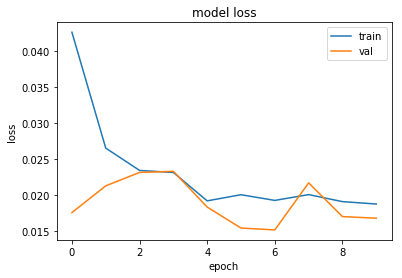

In [21]:
# 优化器 修改为 SGD lr=0.01, momentum=0.6 0.04116
from keras.optimizers import SGD
inputs = Input((X_train.shape[1],))
x = inputs
x = Dropout(0.7)(x)
y = Dense(1, activation='sigmoid')(x)

model = Model(inputs=inputs, outputs=y)
model.compile(loss='binary_crossentropy', optimizer=SGD(lr=0.01,momentum=0.6,decay=1e-6), metrics=['accuracy'])

history = model.fit(x=X_train, y=y_train, batch_size=32, epochs=10, validation_data=(X_val, y_val))

#模型打印
model_print(history)
#测试集
model_test(model, test, test_index)

In [22]:
#gridsearch 选取其他优化器Adagrad Adam Adamax Nadam
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import log_loss, make_scorer
from keras.wrappers.scikit_learn import KerasClassifier
from keras.optimizers import Adagrad, Adam, Adamax, Nadam

def create_model(dropout, optimizer):
    inputs = Input((train.shape[1],))
    x = inputs
    x = Dropout(dropout)(x)
    y = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=inputs, outputs=y)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model
        
model = KerasClassifier(build_fn=create_model, verbose=0)

batch_size = [32]
epochs = [10]
dropout = [0.7]
optimizer = ['adagrad','adam','adamax','nadam']

scorer = make_scorer(log_loss, greater_is_better=False)

param_grid = dict(batch_size=batch_size, nb_epoch=epochs, dropout=dropout, optimizer=optimizer)
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring=scorer)

grid_result = grid.fit(train, train_label)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
for params, mean_score, scores in grid_result.grid_scores_:
    print("%f (%f) with: %r" % (scores.mean(), scores.std(), params))

Best: -0.214144 using {'batch_size': 32, 'dropout': 0.7, 'nb_epoch': 10, 'optimizer': 'adam'}
-0.219670 (0.026359) with: {'batch_size': 32, 'dropout': 0.7, 'nb_epoch': 10, 'optimizer': 'adagrad'}
-0.214144 (0.018014) with: {'batch_size': 32, 'dropout': 0.7, 'nb_epoch': 10, 'optimizer': 'adam'}
-0.241776 (0.038338) with: {'batch_size': 32, 'dropout': 0.7, 'nb_epoch': 10, 'optimizer': 'adamax'}
-0.215525 (0.013395) with: {'batch_size': 32, 'dropout': 0.7, 'nb_epoch': 10, 'optimizer': 'nadam'}


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 6s 320us/step - loss: 0.0416 - acc: 0.9858 - val_loss: 0.0159 - val_acc: 0.9954
Epoch 2/10
20000/20000 [==============================] - 2s 124us/step - loss: 0.0250 - acc: 0.9923 - val_loss: 0.0163 - val_acc: 0.9944
Epoch 3/10
20000/20000 [==============================] - 2s 124us/step - loss: 0.0269 - acc: 0.9924 - val_loss: 0.0159 - val_acc: 0.9948
Epoch 4/10
20000/20000 [==============================] - 2s 124us/step - loss: 0.0243 - acc: 0.9924 - val_loss: 0.0180 - val_acc: 0.9946
Epoch 5/10
20000/20000 [==============================] - 3s 127us/step - loss: 0.0250 - acc: 0.9926 - val_loss: 0.0172 - val_acc: 0.9950
Epoch 6/10
20000/20000 [==============================] - 3s 127us/step - loss: 0.0233 - acc: 0.9938 - val_loss: 0.0202 - val_acc: 0.9944
Epoch 7/10
20000/20000 [==============================] - 2s 124us/step - loss: 0.0232 - acc: 0.9944 - val_loss: 0.0193 - v

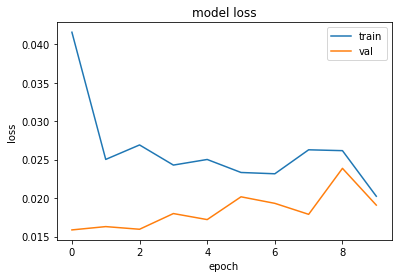

In [25]:
# 优化器 修改为 adam 0.04083
from keras.optimizers import Adamax, Adam
inputs = Input((X_train.shape[1],))
x = inputs
x = Dropout(0.7)(x)
y = Dense(1, activation='sigmoid')(x)

model = Model(inputs=inputs, outputs=y)
model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])

history = model.fit(x=X_train, y=y_train, batch_size=32, epochs=10, validation_data=(X_val, y_val))

#模型打印
model_print(history)
#测试集
model_test(model, test, test_index)

In [5]:
#排除异常后 对比
X, label, train_name = paths_to_tensor('data/train_ext/', 244, 1)

100%|██████████| 24950/24950 [01:07<00:00, 370.86it/s]


NameError: name 'export_gap' is not defined

In [8]:
# 排除异常后特征向量提取
export_gap(InceptionV3, (244,244),preprocess=inception_v3.preprocess_input, ext=True)
export_gap(Xception, (244,244),preprocess=xception.preprocess_input, ext=True)
export_gap(InceptionResNetV2, (244,244), preprocess=inception_resnet_v2.preprocess_input, ext=True)

from sklearn.model_selection import train_test_split
import h5py
train = []
test = []
for file in ['gap_InceptionV3_ext.h5', 'gap_InceptionResNetV2_ext.h5', 'gap_Xception_ext.h5']:
    with h5py.File(file, 'r') as f:
        train.append(np.array(f['train']))
        test.append(np.array(f['test']))
train = np.concatenate(train, axis=1)
test = np.concatenate(test, axis=1)
print(train.shape)
X_train, X_val, y_train, y_val = train_test_split(train, label, shuffle=True, test_size=0.2, random_state=42)

(24950, 5632)


Train on 19960 samples, validate on 4990 samples
Epoch 1/20
19960/19960 [==============================] - 6s 325us/step - loss: 0.1007 - acc: 0.9681 - val_loss: 0.0238 - val_acc: 0.9940
Epoch 2/20
19960/19960 [==============================] - 3s 143us/step - loss: 0.0238 - acc: 0.9931 - val_loss: 0.0186 - val_acc: 0.9952
Epoch 3/20
19960/19960 [==============================] - 3s 143us/step - loss: 0.0205 - acc: 0.9934 - val_loss: 0.0174 - val_acc: 0.9954
Epoch 4/20
19960/19960 [==============================] - 3s 143us/step - loss: 0.0182 - acc: 0.9945 - val_loss: 0.0168 - val_acc: 0.9952
Epoch 5/20
19960/19960 [==============================] - 3s 143us/step - loss: 0.0181 - acc: 0.9945 - val_loss: 0.0165 - val_acc: 0.9954
Epoch 6/20
19960/19960 [==============================] - 3s 142us/step - loss: 0.0171 - acc: 0.9952 - val_loss: 0.0165 - val_acc: 0.9952
Epoch 7/20
19960/19960 [==============================] - 3s 143us/step - loss: 0.0167 - acc: 0.9948 - val_loss: 0.0164 - v

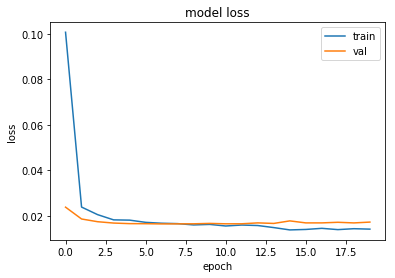

In [9]:
# 优化器 RMSprop lr=0.0001  
from keras.optimizers import RMSprop
inputs = Input((X_train.shape[1],))
x = inputs
x = Dropout(0.5)(x)
y = Dense(1, activation='sigmoid')(x)

model = Model(inputs=inputs, outputs=y)
model.compile(loss='binary_crossentropy', optimizer=RMSprop(lr=0.0001), metrics=['accuracy'])

history = model.fit(x=X_train, y=y_train, batch_size=32, epochs=20, validation_data=(X_val, y_val))

#模型打印
model_print(history)
#测试集
model_test(model, test, test_index)

In [13]:
#改为299*299分批读入
def export_gap3(MODEL, size, path, preprocess=None):
    
    X_t, train_label_t, name = paths_to_tensor(path, size, 1)
    
    x = Input((size, size, 3))
    if preprocess:
        x = Lambda(preprocess)(x)
    model = MODEL(input_tensor=x, weights='imagenet', include_top=False, pooling='avg')

    train_gap = model.predict(X_t, batch_size=256)
    
    with h5py.File("./train3-h5/gap_%s_%s.h5" % (path.split('/')[-1], MODEL.__name__), 'w') as f:
        f.create_dataset('train', data=train_gap)
    return train_label_t

def export_gap3_test(MODEL, size, path, preprocess=None):
    
    X_t, test_index = paths_to_tensor(path, size, 0)
    
    x = Input((size, size, 3))
    if preprocess:
        x = Lambda(preprocess)(x)
    model = MODEL(input_tensor=x, weights='imagenet', include_top=False, pooling='avg')

    test_gap = model.predict(X_t, batch_size=256)
    
    with h5py.File("./train3-h5/gap_%s_%s_test.h5" % (path.split('/')[-1], MODEL.__name__), 'w') as f:
        f.create_dataset('test', data=test_gap)
    return test_index

In [8]:
label_1 = export_gap3(InceptionV3, 299, 'data/train3/1', inception_v3.preprocess_input)

100%|██████████| 8334/8334 [00:24<00:00, 341.72it/s]


In [9]:
export_gap3(Xception, 299, 'data/train3/1', xception.preprocess_input)
export_gap3(InceptionResNetV2, 299, 'data/train3/1', inception_resnet_v2.preprocess_input)

100%|██████████| 8334/8334 [00:24<00:00, 337.14it/s]


array([0, 1, 0, ..., 0, 0, 0])

In [11]:
label_2 = export_gap3(InceptionV3, 299, 'data/train3/2', inception_v3.preprocess_input)
export_gap3(Xception, 299, 'data/train3/2', xception.preprocess_input)
export_gap3(InceptionResNetV2, 299, 'data/train3/2', inception_resnet_v2.preprocess_input)

100%|██████████| 8333/8333 [00:24<00:00, 335.29it/s]


array([1, 0, 1, ..., 0, 1, 1])

In [12]:
label_3 = export_gap3(InceptionV3, 299, 'data/train3/3', inception_v3.preprocess_input)
export_gap3(Xception, 299, 'data/train3/3', xception.preprocess_input)
export_gap3(InceptionResNetV2, 299, 'data/train3/3', inception_resnet_v2.preprocess_input)

100%|██████████| 8333/8333 [00:24<00:00, 334.12it/s]


array([1, 1, 0, ..., 1, 0, 0])

In [14]:
test_index = export_gap3_test(InceptionV3, 299, 'data/test/', inception_v3.preprocess_input)

100%|██████████| 12500/12500 [00:56<00:00, 222.78it/s]


In [15]:
export_gap3_test(Xception, 299, 'data/test/', xception.preprocess_input)
export_gap3_test(InceptionResNetV2, 299, 'data/test/', inception_resnet_v2.preprocess_input)

100%|██████████| 12500/12500 [00:37<00:00, 329.60it/s]


[9240,
 4878,
 12223,
 8198,
 8625,
 11285,
 248,
 9479,
 5011,
 6282,
 1758,
 9483,
 11914,
 11802,
 12411,
 7756,
 1295,
 2590,
 11616,
 11839,
 74,
 377,
 8760,
 11976,
 7091,
 5829,
 1878,
 4739,
 401,
 8212,
 217,
 4302,
 6670,
 2373,
 2655,
 7863,
 10918,
 5013,
 4686,
 10434,
 7798,
 12357,
 10982,
 2208,
 3419,
 6026,
 1496,
 2720,
 10641,
 7674,
 12451,
 8389,
 8797,
 10915,
 1441,
 11640,
 9681,
 11755,
 2022,
 5003,
 4377,
 1771,
 1505,
 12007,
 10608,
 8366,
 11929,
 6414,
 12453,
 2631,
 4210,
 1663,
 7800,
 9481,
 4884,
 926,
 10511,
 11796,
 3703,
 7734,
 7236,
 5734,
 6497,
 564,
 1701,
 10827,
 3556,
 11934,
 3663,
 4218,
 2583,
 5462,
 9934,
 3046,
 1020,
 10665,
 8739,
 7508,
 823,
 12165,
 9069,
 15,
 11492,
 2177,
 10692,
 935,
 336,
 8913,
 8685,
 3218,
 2131,
 2455,
 4246,
 2181,
 992,
 11539,
 1144,
 8238,
 9458,
 11772,
 2684,
 4511,
 12138,
 4204,
 2711,
 3674,
 3643,
 5788,
 11368,
 2098,
 7181,
 1780,
 11838,
 9217,
 6243,
 4714,
 8763,
 723,
 12338,
 6330,


In [17]:
train1 = []
for file in ['./train3-h5/gap_1_InceptionResNetV2.h5', './train3-h5/gap_1_InceptionV3.h5', './train3-h5/gap_1_Xception.h5']:
    with h5py.File(file, 'r') as f:
        train1.append(np.array(f['train']))
train1 = np.concatenate(train1, axis=1)
print(train1.shape)

(8334, 5632)


In [18]:
train2 = []
for file in ['./train3-h5/gap_2_InceptionResNetV2.h5', './train3-h5/gap_2_InceptionV3.h5', './train3-h5/gap_2_Xception.h5']:
    with h5py.File(file, 'r') as f:
        train2.append(np.array(f['train']))
train2 = np.concatenate(train2, axis=1)
print(train2.shape)

(8333, 5632)


In [20]:
train3 = []
for file in ['./train3-h5/gap_3_InceptionResNetV2.h5', './train3-h5/gap_3_InceptionV3.h5', './train3-h5/gap_3_Xception.h5']:
    with h5py.File(file, 'r') as f:
        train3.append(np.array(f['train']))
train3 = np.concatenate(train3, axis=1)
print(train3.shape)

(8333, 5632)


In [21]:
test = []
for file in ['./train3-h5/gap__InceptionResNetV2_test.h5', './train3-h5/gap__InceptionV3_test.h5', './train3-h5/gap__Xception_test.h5']:
    with h5py.File(file, 'r') as f:
        test.append(np.array(f['test']))
test = np.concatenate(test, axis=1)
print(test.shape)

(12500, 5632)


In [23]:
train = np.concatenate((train1, train2, train3))
train.shape

(25000, 5632)

In [24]:
train_label = np.concatenate((label_1, label_2, label_3))
train_label.shape

(25000,)

In [25]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(train, train_label, shuffle=True, test_size=0.2, random_state=42)

Train on 20000 samples, validate on 5000 samples
Epoch 1/20
20000/20000 [==============================] - 32s 2ms/step - loss: 0.0992 - acc: 0.9788 - val_loss: 0.0266 - val_acc: 0.9926
Epoch 2/20
20000/20000 [==============================] - 7s 332us/step - loss: 0.0232 - acc: 0.9937 - val_loss: 0.0205 - val_acc: 0.9936
Epoch 3/20
20000/20000 [==============================] - 7s 332us/step - loss: 0.0188 - acc: 0.9949 - val_loss: 0.0207 - val_acc: 0.9932
Epoch 4/20
20000/20000 [==============================] - 7s 332us/step - loss: 0.0170 - acc: 0.9946 - val_loss: 0.0179 - val_acc: 0.9946
Epoch 5/20
20000/20000 [==============================] - 7s 331us/step - loss: 0.0156 - acc: 0.9954 - val_loss: 0.0177 - val_acc: 0.9946
Epoch 6/20
20000/20000 [==============================] - 7s 332us/step - loss: 0.0151 - acc: 0.9953 - val_loss: 0.0175 - val_acc: 0.9944
Epoch 7/20
20000/20000 [==============================] - 7s 332us/step - loss: 0.0150 - acc: 0.9950 - val_loss: 0.0181 - va

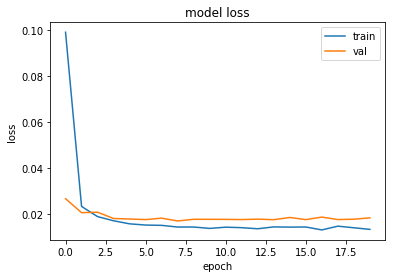

In [27]:
# 优化器 修改为 RMSprop lr=0.0001 0.03916
from keras.optimizers import RMSprop
inputs = Input((X_train.shape[1],))
x = inputs
x = Dropout(0.5)(x)
y = Dense(1, activation='sigmoid')(x)

model = Model(inputs=inputs, outputs=y)
model.compile(loss='binary_crossentropy', optimizer=RMSprop(lr=0.0001), metrics=['accuracy'])

history = model.fit(x=X_train, y=y_train, batch_size=32, epochs=20, validation_data=(X_val, y_val))

#模型打印
model_print(history)
#测试集
model_test(model, test, test_index)